In [1]:
############################
## Tradingview Integration
############################

In [2]:
import os
import numpy as np
import pandas as pd
import mplfinance as mpl
import yfinance as yf
import ta
import pandas_ta
import talib
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

from tradingview_ta import TA_Handler, Interval
from price_data_functions import data_reader
from polynomial_fit import poly_fit
from poly_fit_model import poly_model

from binance.client import Client
from binance import BinanceSocketManager

from jupyterthemes.stylefx import set_nb_theme
from IPython.display import display, HTML

In [3]:
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

set_nb_theme('onedork')

Model return: 
mod_ret    0.299388
ret       -0.369508
dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Confusion matrix:              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2139
           1       0.52      0.50      0.51      2108

    accuracy                           0.53      4247
   macro avg       0.52      0.52      0.52      4247
weighted avg       0.52      0.53      0.52      4247



~~~~~~~~~~~~~~

1 minute price:


open: 30270
high: 30270
low: 30270


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




5 minute interval signal:

{'RECOMMENDATION': 'BUY', 'BUY': 13, 'SELL': 5, 'NEUTRAL': 8}

Buy signal strength:1.4444444444444444

Sell signal strength:0.29411764705882354

~~~~~~~~~~~~~~~~~~~~~~~~~~~~

15 minute interval signal:

{'RECOMMENDATION': 'NEUTRAL', 'BUY': 8, 'SELL': 8, 'NEUTRAL': 10}

Buy signal strength:0.6153846153846154

Sell signal strength:0.6153846153846

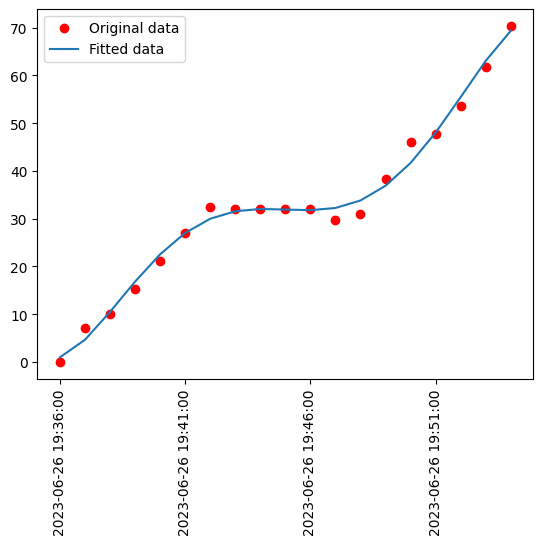

Feature vector classification:
[0]


Signal not confirmed by model...

 Not opening buy position...


~~~~~~~~~~~~~~

1 minute price:


open: 30270
high: 30300.42
low: 30270


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




5 minute interval signal:

{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 15, 'SELL': 2, 'NEUTRAL': 9}

Buy signal strength:2.3076923076923075

Sell signal strength:0.10256410256410256

~~~~~~~~~~~~~~~~~~~~~~~~~~~~

15 minute interval signal:

{'RECOMMENDATION': 'BUY', 'BUY': 10, 'SELL': 6, 'NEUTRAL': 10}

Buy signal strength:0.9090909090909091

Sell signal strength:0.4




~~~~~~~~~~~~~~

1 minute price:


open: 30270
high: 30300.42
low: 30270


Checking signal...




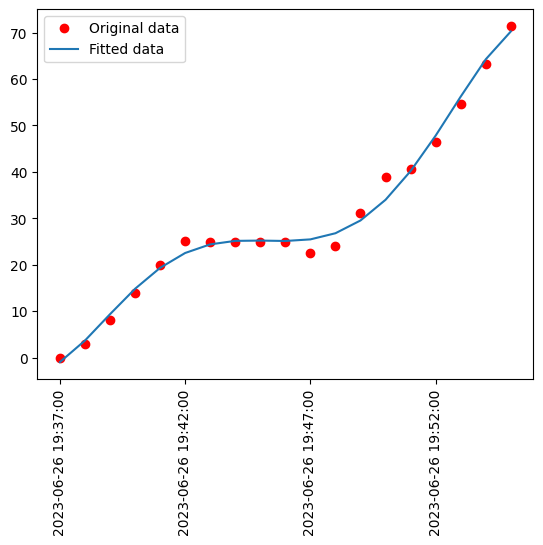

Feature vector classification:
[0]


Signal not confirmed by model...

 Not opening buy position...


~~~~~~~~~~~~~~

1 minute price:


open: 30300.78
high: 30300.78
low: 30300.78


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




5 minute interval signal:

{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 15, 'SELL': 2, 'NEUTRAL': 9}

Buy signal strength:2.3076923076923075

Sell signal strength:0.10256410256410256

~~~~~~~~~~~~~~~~~~~~~~~~~~~~

15 minute interval signal:

{'RECOMMENDATION': 'BUY', 'BUY': 10, 'SELL': 6, 'NEUTRAL': 10}

Buy signal strength:0.9090909090909091

Sell signal strength:0.4




~~~~~~~~~~~~~~

1 minute price:


open: 30300.78
high: 30300.78
low: 30300.78


Checking signal...




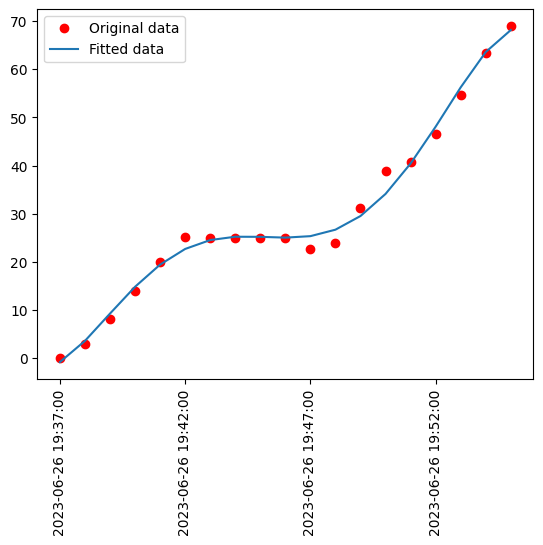

Feature vector classification:
[0]


Signal not confirmed by model...

 Not opening buy position...


~~~~~~~~~~~~~~

1 minute price:


open: 30300.78
high: 30300.78
low: 30300.78


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




5 minute interval signal:

{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 15, 'SELL': 2, 'NEUTRAL': 9}

Buy signal strength:2.3076923076923075

Sell signal strength:0.10256410256410256

~~~~~~~~~~~~~~~~~~~~~~~~~~~~

15 minute interval signal:

{'RECOMMENDATION': 'BUY', 'BUY': 10, 'SELL': 6, 'NEUTRAL': 10}

Buy signal strength:0.9090909090909091

Sell signal strength:0.4




~~~~~~~~~~~~~~

1 minute price:


open: 30300.78
high: 30300.78
low: 30300.78


Checking signal...




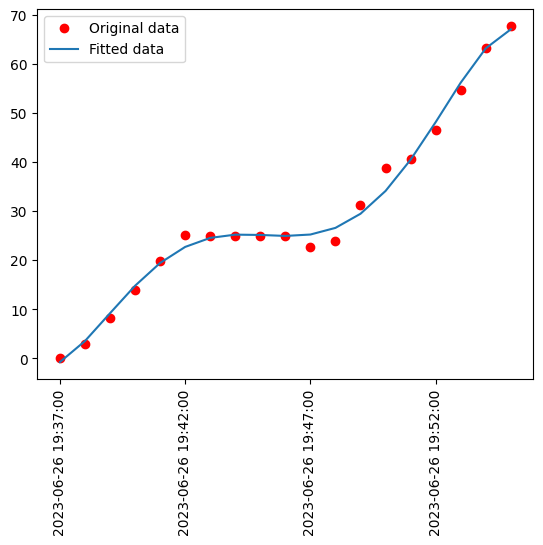

Feature vector classification:
[0]


Signal not confirmed by model...

 Not opening buy position...


KeyboardInterrupt: 

In [4]:
## Strategy

# Run models and check conditions when based on buy and sell recommendations from Tradingview

def main():
    
    #Data pipeline functions
    def get_predict_data():
        #Data_reader class for two intervals
        dr_poly = data_reader()
        dr_poly.set_period('1m')
        dr_poly.set_start('30 minute ago')
        dr_30 = data_reader()
        dr_30.set_period('30m')
        dr_30.set_start('1 day ago')
        #Download data
        df_poly = dr_poly.get_price_data()
        df_30 = dr_30.get_price_data()
        #Fit SMA to polynomial curve
        fit = poly_fit(df_poly).arr[0]
        fit[-2] = np.exp(fit[-2])
        fit[-1] = np.exp(fit[-1])
        feature_vector = np.append(dr_30.feature_vector, fit)
        return feature_vector
    
    def check_signal():
        #Check recommendation
        print('\n\nChecking signal...\n\n')
        if signal_15m['RECOMMENDATION'] == 'STRONG_BUY' or buy_sig_strength_15m >= 0.8:
            if signal_5m['RECOMMENDATION'] == 'STRONG_BUY' or buy_sig_strength_5m >= 0.8:
                predict_fv = get_predict_data() 
                prediction = pm.predict(predict_fv)
                if prediction == 1:
                    print('\n\nSignal confirmed by model...\n\n Opening buy position...')
                    open_position = True
                else:
                    print('\n\nSignal not confirmed by model...\n\n Not opening buy position...')
        elif signal_15m['RECOMMENDATION'] == 'STRONG_SELL' or sell_sig_strength_15m >= 0.8:
            if signal_5m['RECOMMENDATION'] == 'STRONG_SELL' or sell_sig_strength_5m >= 0.8:
                predict_fv = get_predict_data() 
                prediction = pm.predict(predict_fv)
                if prediction == 0:
                    print('\n\nSignal confirmed by model...\n\n Opening short position...')
                    open_position = True
                else:
                    print('\n\nSignal not confirmed by model...\n\n Not opening short position...')
        
        
        #Wait 10 seconds to check again
        time.sleep(10)
        
    
    
    #Tradingview analysis for 1, 5, and 15 minute intervals
    ta_1m = TA_Handler(symbol = 'BTCUSDT', 
                    screener = 'Crypto', 
                    exchange = 'Binance', 
                    interval = Interval.INTERVAL_1_MINUTE
                   )
    ta_5m = TA_Handler(symbol = 'BTCUSDT', 
                    screener = 'Crypto', 
                    exchange = 'Binance', 
                    interval = Interval.INTERVAL_5_MINUTES
                   )
    ta_15m = TA_Handler(symbol = 'BTCUSDT', 
                    screener = 'Crypto', 
                    exchange = 'Binance', 
                    interval = Interval.INTERVAL_15_MINUTES
                   )
    
    #Binance price data to predict on
    dr_poly = data_reader()
    dr_poly.set_period('1m')
    dr_poly.set_start('30 minute ago')
    dr_30 = data_reader()
    dr_30.set_period('30m')
    dr_30.set_start('1 day ago')
    
    #Logistic regression model
    pm = poly_model()
    
    #Main loop
    running = True
    while running:
        #In position
        open_position = False
        
        #Get Tradingview signals
        ta_data_5m = ta_5m.get_analysis().indicators #Tradingview data and technical indicators
        ta_data_5m = ta_15m.get_analysis().indicators
        signal_5m = ta_5m.get_analysis().summary
        signal_15m = ta_15m.get_analysis().summary
        buy_sig_strength_5m = signal_5m['BUY'] / (signal_5m['SELL'] + 0.5 * signal_5m['NEUTRAL'])
        buy_sig_strength_15m = signal_15m['BUY'] / (signal_15m['SELL'] + 0.5 * signal_15m['NEUTRAL'])
        sell_sig_strength_5m = signal_5m['SELL'] / (signal_5m['BUY'] + 0.5 * signal_5m['NEUTRAL'])
        sell_sig_strength_15m = signal_15m['SELL'] / (signal_15m['BUY'] + 0.5 * signal_15m['NEUTRAL'])
        #Recent price
        ta_data_1m = ta_1m.get_analysis().indicators
        ohl_1m = {k:v for (k,v) in [(i, ta_data_1m[i]) for i in ["open","high","low"]]} #Dictionary comprehension for 1 minute open, high, low values
        #Print information
        print('\n\n~~~~~~~~~~~~~~\n\n1 minute price:\n\n') 
        for i in (f'{k}: {v}' for k,v in ohl_1m.items()):
            print(i)
        print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')
        print(f'\n\n5 minute interval signal:\n\n{signal_5m}\n\nBuy signal strength:{buy_sig_strength_5m}\n\nSell signal strength:{sell_sig_strength_5m}\n\n~~~~~~~~~~~~'\
              f'~~~~~~~~~~~~~~~~\n\n15 minute interval signal:\n\n{signal_15m}\n\nBuy signal strength:{buy_sig_strength_15m}\n\nSell signal strength:{sell_sig_strength_15m}\n\n')
        time.sleep(1)
        ta_data_1m = ta_1m.get_analysis().indicators
        ohl_1m = {k:v for (k,v) in [(i, ta_data_1m[i]) for i in ["open","high","low"]]}
        print('\n\n~~~~~~~~~~~~~~\n\n1 minute price:\n\n')
        for i in (f'{k}: {v}' for k,v in ohl_1m.items()): #Recent price 
            print(i)
        
        #Check recommendation
        check_signal()
        
        
        
            
            
        
    
    
    
    
if __name__ == "__main__":
    main()